In [1]:
import sys
sys.path.append('E:/zlab')
from loader import Loader
from xtrain import XModel

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 载入数据

In [2]:
import tables as tb
import numpy as np

h5 = tb.open_file('E:/xdata/X.h5')
#h5 = tb.open_file('./X.h5')

data = h5.root.cifar10

## 划分数据集

In [3]:
from sklearn.model_selection import train_test_split

X = data.trainX[:]
y = data.trainY[:]
X_train, X_unlabel, y_train, y_unlabel = train_test_split(
    X, y, test_size=0.98, random_state=42)

batch_size = 32
trainset = Loader(batch_size, X_train, y_train, shuffle=True, name='train')
testset = Loader(
    batch_size, data.testX, data.testY, shuffle=False, name='test')
unlabelset = Loader(
    batch_size,
    X_unlabel[:10000],
    y_unlabel[:10000],
    shuffle=False,
    name='agent')

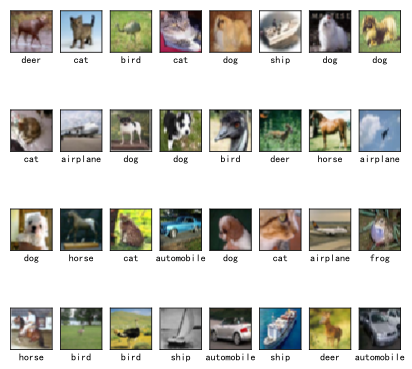

In [4]:
for imgs, labels in iter(trainset):
    trainset.show_imgs(data.label_names, imgs.astype(np.uint8), labels)
    break

# 模型的配置

In [5]:
from mxnet.gluon import nn, model_zoo
from mxnet import nd, init


class SemiModel(nn.HybridBlock):
    def __init__(self, features, **kwargs):
        super().__init__(**kwargs)
        self.features = features
        self.features1 = nn.HybridSequential()
        self.features.add(nn.Dense(1024), nn.Activation('relu'))
        self.output = nn.Dense(10)

    def hybrid_forward(self, F, x):
        x = self.features(x)
        x= self.features1(x)
        return self.output(x)


pretrain_net = model_zoo.vision.resnet50_v2(pretrained=False)
net = SemiModel(pretrain_net.features)
net.hybridize()

# 网络预设
_net = model_zoo.vision.resnet50_v2(pretrained=True)
net.features = _net.features
net.features1.initialize(init.Xavier(magnitude=0.24))
net.output.initialize(init.Xavier(magnitude=0.24))

# 超参数设定
epochs = 500
learning_rate = 0.1
model = XModel(learning_rate)
ctx = model.ctx
print('training on', ctx)
net.collect_params().reset_ctx(ctx)

training on gpu(0)


# 训练有标签数据

In [6]:
epochs = 500
net = model.train(net, trainset, testset, epochs, start=0)

Epoch 0, loss 5.43469, train acc 0.099, test_acc 0.1, time 33.0 sec
Epoch 1, loss 4.14628, train acc 0.098, test_acc 0.1005, time 17.0 sec
Epoch 2, loss 3.45678, train acc 0.106, test_acc 0.1568, time 17.1 sec
Epoch 3, loss 3.03993, train acc 0.138, test_acc 0.1573, time 17.4 sec
Epoch 4, loss 2.81219, train acc 0.157, test_acc 0.1186, time 16.8 sec
Epoch 5, loss 2.66218, train acc 0.172, test_acc 0.1797, time 16.8 sec
Epoch 6, loss 2.44381, train acc 0.182, test_acc 0.1352, time 16.6 sec
Epoch 7, loss 2.34242, train acc 0.2, test_acc 0.1683, time 16.9 sec
Epoch 8, loss 2.19788, train acc 0.21, test_acc 0.1834, time 17.0 sec
Epoch 9, loss 2.14696, train acc 0.218, test_acc 0.137, time 16.0 sec
Epoch 10, loss 2.00998, train acc 0.254, test_acc 0.2028, time 16.0 sec
Epoch 11, loss 1.93762, train acc 0.267, test_acc 0.2302, time 16.5 sec
Epoch 12, loss 1.91373, train acc 0.275, test_acc 0.1936, time 16.9 sec
Epoch 13, loss 1.86022, train acc 0.292, test_acc 0.2864, time 16.8 sec
Epoch 14,

Epoch 114, loss 0.351117, train acc 0.894, test_acc 0.3092, time 16.0 sec
Epoch 115, loss 0.448035, train acc 0.864, test_acc 0.3363, time 16.1 sec
Epoch 116, loss 0.381522, train acc 0.889, test_acc 0.3773, time 16.1 sec
Epoch 117, loss 0.195709, train acc 0.952, test_acc 0.3785, time 15.9 sec
Epoch 118, loss 0.122371, train acc 0.981, test_acc 0.397, time 15.9 sec
Epoch 119, loss 0.260068, train acc 0.926, test_acc 0.3052, time 16.1 sec
Epoch 120, loss 0.427748, train acc 0.874, test_acc 0.3777, time 15.9 sec
Epoch 121, loss 0.20533, train acc 0.953, test_acc 0.3918, time 15.9 sec
Epoch 122, loss 0.117127, train acc 0.98, test_acc 0.3941, time 16.0 sec
Epoch 123, loss 0.129012, train acc 0.976, test_acc 0.3926, time 15.9 sec
Epoch 124, loss 0.0856815, train acc 0.994, test_acc 0.407, time 16.0 sec
Epoch 125, loss 0.0503774, train acc 0.998, test_acc 0.4213, time 16.0 sec
Epoch 126, loss 0.0376069, train acc 1, test_acc 0.4319, time 16.0 sec
Epoch 127, loss 0.0379626, train acc 1, tes

Epoch 226, loss 0.0378755, train acc 1, test_acc 0.4141, time 16.4 sec
Epoch 227, loss 0.0342668, train acc 0.999, test_acc 0.4003, time 16.6 sec
Epoch 228, loss 0.0436419, train acc 0.999, test_acc 0.4151, time 43.4 sec
Epoch 229, loss 0.0424639, train acc 0.999, test_acc 0.413, time 17.0 sec
Epoch 230, loss 0.0377791, train acc 1, test_acc 0.4196, time 16.7 sec
Epoch 231, loss 0.0376082, train acc 1, test_acc 0.4129, time 16.8 sec
Epoch 232, loss 0.0421587, train acc 0.999, test_acc 0.3804, time 16.9 sec
Epoch 233, loss 1.08898, train acc 0.639, test_acc 0.2918, time 16.7 sec
Epoch 234, loss 0.817715, train acc 0.742, test_acc 0.3177, time 16.6 sec
Epoch 235, loss 0.45413, train acc 0.865, test_acc 0.2866, time 16.5 sec
Epoch 236, loss 0.34576, train acc 0.903, test_acc 0.3255, time 16.6 sec
Epoch 237, loss 0.267638, train acc 0.934, test_acc 0.3634, time 16.5 sec
Epoch 238, loss 0.132464, train acc 0.974, test_acc 0.3817, time 16.6 sec
Epoch 239, loss 0.135572, train acc 0.976, test

KeyboardInterrupt: 

In [ ]:
nn.Embedding?

# 数据打包

# 训练和调优